extract actual inpainting from inference_inpainting

In [1]:
import torch
import numpy as np

import cv2

from src.config import config
from src.experiments.resources import load_data
from src.experiments.imputations import get_segmentation 
from src.datasets.imagenet import unnormalize_image

import matplotlib.pyplot as plt

#for PUT
from inference_inpainting import (get_model, inference_inpainting)

import copy
from types import SimpleNamespace


In [2]:
# args

model_args = SimpleNamespace(model_name='/media/vielhaben/Data1/PredDiff/PUT/imagenet/checkpoints/000044e_600524iter.pth') # yaml config file must be in same 

load model

In [3]:
info = get_model(args=model_args, model_name=model_args.model_name)  
model = info['model']
model = model.cuda()

/home/vielhaben/git/conditional-explainer/src/put_imputer/image_synthesis/modeling/codecs/image_codec/patch_vqgan.py:898: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v).view(1, -1, 1, 1)


{'overall': {'trainable': '421.198Mb; 441.658M', 'non_trainable': '7.058Mb; 7.401M', 'total': '428.757Mb; 449.584M', 'buffer': '513.0Kb; 525.312K'}, 'content_codec': {'trainable': '0b; 0', 'non_trainable': '7.058Mb; 7.401M', 'buffer': '513.0Kb; 525.312K', 'total': '7.559Mb; 7.927M'}, 'emb_proj': {'trainable': '257.0Kb; 263.168K', 'non_trainable': '0b; 0', 'buffer': '0b; 0', 'total': '257.0Kb; 263.168K'}, 'blocks': {'trainable': '420.444Mb; 440.868M', 'non_trainable': '0b; 0', 'buffer': '0b; 0', 'total': '420.444Mb; 440.868M'}, 'layer_norm': {'trainable': '2.0Kb; 2.048K', 'non_trainable': '0b; 0', 'buffer': '0b; 0', 'total': '2.0Kb; 2.048K'}, 'to_logits': {'trainable': '512.5Kb; 524.8K', 'non_trainable': '0b; 0', 'buffer': '0b; 0', 'total': '512.5Kb; 524.8K'}, 'total': '429.757Mb; 450.633M'}
Missing keys in created model:
 []
Unexpected keys in state dict:
 []


load image and mask

normalization, mask convention, etc.?

ATTENTION: image needs to be float in [0,255] -> in conditional explainer pipeline we need to unnormalize, *255 and back after inpaiting!!

In [4]:
# image is read in with
## image = Image.open(image_path).convert('RGB')
# ATTENTION: image needs to be float in [0,255]
# and only resized with 
## image_inp = cv2.resize(image, tuple(self.size), interpolation=cv2.INTER_LINEAR)
# shape is # 3, h, w

dataset = config.DatasetConfig('imagenet', root_data='/media/vielhaben/Data1/ImageNet-complete', image_size=224)

test_images = load_data(dataset=dataset, n_samples=2, train=False, format_numpy=True)

test_images_list = []
for img in test_images:
    test_image = unnormalize_image(img)

    test_image = cv2.resize(test_image.transpose(1,2,0), (256,256), interpolation=cv2.INTER_LINEAR).transpose(2,0,1) # w,h=225,156

    test_image = torch.tensor((test_image.astype(np.float32))*255).unsqueeze(0)

    test_images_list.append(test_image)

test_images = torch.cat(test_images_list)

In [5]:
test_images.size()

torch.Size([2, 3, 256, 256])

In [6]:
# mask is float 0.0 and 1.0
# shape is # 1, h, w

mask_list = []
for test_image in test_images:

    segmentation_config = config.SegmentationConfig(name='slic', n_superpixel=25, compactness_slic=1.0)

    segmentation = get_segmentation(segmentation_config, test_image, n_occluded_superpixels=10)

    mask = np.greater_equal(segmentation, 0)[:1]

    mask = torch.tensor(mask).bool()

    mask_list.append(mask.unsqueeze(0))

masks = torch.cat(mask_list)

In [33]:
mask.size()

torch.Size([1, 256, 256])

Alternative: Get model and data from inference_inpainting

In [3]:
args = SimpleNamespace(func='inference_inpainting',
                    name='/media/vielhaben/Data1/PredDiff/PUT/imagenet/checkpoints/000044e_600524iter.pth',
                    image_dir='/media/vielhaben/Data1/PredDiff/PUT/test_image_2/ILSVRC2012_val_00002668.JPEG',
                    mask_dir='/media/vielhaben/Data1/PredDiff/PUT/test_mask_1/00015.png',
                    save_dir='',
                    input_res='256,256',
                    num_sample=1,
                    gpu=1,
                    num_token_for_sampling='1',
                    filter_ratio='1',
                    num_token_per_iter='1',
                    raster_order=False,
                    save_masked_image=False,
                    num_replicate=1,
                    dist_url='auto',
                    world_size=1
                    )



In [46]:
model,data=inference_inpainting(args=args)

/home/vielhaben/git/conditional-explainer/src/put_imputer/image_synthesis/modeling/codecs/image_codec/patch_vqgan.py:898: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v).view(1, -1, 1, 1)


{'overall': {'trainable': '421.198Mb; 441.658M', 'non_trainable': '7.058Mb; 7.401M', 'total': '428.757Mb; 449.584M', 'buffer': '513.0Kb; 525.312K'}, 'content_codec': {'trainable': '0b; 0', 'non_trainable': '7.058Mb; 7.401M', 'buffer': '513.0Kb; 525.312K', 'total': '7.559Mb; 7.927M'}, 'emb_proj': {'trainable': '257.0Kb; 263.168K', 'non_trainable': '0b; 0', 'buffer': '0b; 0', 'total': '257.0Kb; 263.168K'}, 'blocks': {'trainable': '420.444Mb; 440.868M', 'non_trainable': '0b; 0', 'buffer': '0b; 0', 'total': '420.444Mb; 440.868M'}, 'layer_norm': {'trainable': '2.0Kb; 2.048K', 'non_trainable': '0b; 0', 'buffer': '0b; 0', 'total': '2.0Kb; 2.048K'}, 'to_logits': {'trainable': '512.5Kb; 524.8K', 'non_trainable': '0b; 0', 'buffer': '0b; 0', 'total': '512.5Kb; 524.8K'}, 'total': '429.757Mb; 450.633M'}
Missing keys in created model:
 []
Unexpected keys in state dict:
 []
fr 1
ntp 1
results will be saved in RESULT/config_e44/00015.png_top1_nTpi1_numSample1
PATHS ['/media/vielhaben/Data1/PredDiff/PU

inference

In [7]:
model.cuda()

MaskedImageInpaintingTransformer(
  (content_codec): PatchVQGAN(
    (encoder): PatchEncoder2(
      (pre_layers): Sequential(
        (0): Linear(in_features=192, out_features=256, bias=True)
      )
      (res_layers): Sequential(
        (0): LinearResBlock(
          (layers): Sequential(
            (0): ReLU(inplace=True)
            (1): Linear(in_features=256, out_features=128, bias=True)
            (2): ReLU(inplace=True)
            (3): Linear(in_features=128, out_features=256, bias=True)
          )
        )
        (1): LinearResBlock(
          (layers): Sequential(
            (0): ReLU(inplace=True)
            (1): Linear(in_features=256, out_features=128, bias=True)
            (2): ReLU(inplace=True)
            (3): Linear(in_features=128, out_features=256, bias=True)
          )
        )
        (2): LinearResBlock(
          (layers): Sequential(
            (0): ReLU(inplace=True)
            (1): Linear(in_features=256, out_features=128, bias=True)
          

In [37]:
data_i = {'image':test_image.unsqueeze(dim=0).cuda(),
          'mask':mask.unsqueeze(dim=0).cuda()} 

In [8]:
data_i = {'image':test_images.cuda(),
          'mask':masks.cuda()} 

In [9]:
fr = 1 # their default, filter ratio = num_token_for_sampling = 'the top-k tokens remained for sampling for each patch'
ntp = 1 # num_token_per_iter = 'the number of patches to be inpainted in one iteration'
accumulate_time = None
raster_order = False # 'Get the k1 patches in a raster order'?

In [10]:
with torch.no_grad():
    content_dict = model.generate_content(
        batch=copy.deepcopy(data_i),
        filter_ratio=fr,
        filter_type='count',
        replicate=1, # if args.num_sample == 1 else args.num_replicate,
        with_process_bar=True,
        mask_low_to_high=True,
        sample_largest=True,
        calculate_acc_and_prob=False,
        num_token_per_iter=ntp,
        accumulate_time=accumulate_time,
        raster_order=raster_order,
        return_reconstruction=False,
        #return_att_weight=Tru

    ) # B x C x H x W

/home/vielhaben/anaconda3/envs/preddiff/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(1438, device='cuda:0') 2048
tensor(1638, device='cuda:0') 2048
tensor(1838, device='cuda:0') 2048
tensor(2038, device='cuda:0') 2048


In [12]:
torch.cuda.max_memory_allocated() *1e-9

2.03237632

In [13]:
content_dict.keys()

dict_keys(['completed'])

In [14]:
content_dict['completed'].cpu().numpy().shape

(2, 3, 256, 256)

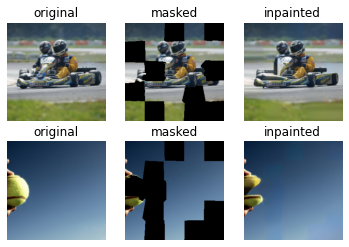

In [31]:
_,ax = plt.subplots(2,3)

for i in range(2):
    image = data_i['image'].cpu().numpy()[i].transpose(1,2,0)/256
    ax[i,0].imshow(image)
    ax[i,0].axis('off')
    ax[i,0].set_title('original')

    image_masked = data_i['image'].cpu().numpy()[i].transpose(1,2,0)/255 * data_i['mask'].cpu().numpy()[i].transpose(1,2,0)
    ax[i,1].imshow(image_masked)
    ax[i,1].axis('off')
    ax[i,1].set_title('masked')

    image_inpainted = content_dict['completed'].cpu().numpy()[i]
    ax[i,2].imshow(image_inpainted.transpose(1,2,0)/255)
    ax[i,2].axis('off')
    ax[i,2].set_title('inpainted')